<div class="alert alert-success">
<h1>Feature Selection Lab</h1>
<h2>ASI Lab - 01/06/2017</h2>
</div>

<h2>1. Aims</h2>
<p>
<ul>
<li>To pick some features from the leukaemia data.
</ul>

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import scipy
import scipy.io as sio
import time as time
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 10.0)

<h2>2. Feature Selection</h2>

Like last week, this lab is quite open-ended. On the course webpage, you can download a (slightly reduced) version of the leukaemia data. It consists of some training data $X$ and associated labels $t$ as well as independent test data $X_test$ and $t_test$. Your task is to select some features and classify the data – in previous labs we have provided code for classiﬁcation (SVM, KNN, Bayes) and you may use whichever you like.

<div class="alert alert-warning">
Let's load the data from the <code>labdata.mat</code> file.
</div>

In [94]:
data = sio.loadmat('./Lab5/labdata.mat')
X = data['X']
X_test = data['X_test']
t = data['t']
t_test = data['t_test']

<h3>2.1 Feature Selection</h3>

You are free to use any of the feature selection schemes we covered in class – scoring the features, PCA, or clustering them (you should have K-means code from last week to do this). In each case, you should use the test set to investigate how performance varies as you change the number.

<h4>2.1.1 Scoring</h4>

Use the score described in the lectures (only on the training data) to get a set of features (corre-sponding to a subset of the original ones). You should make sure you extract this subset from the test data too!

In [95]:
def compute_s(X, t):
    for i in range(X.size):
        train_x = np.delete(X, i)
        train_t = np.delete(t, i)
        pred = makePredictions(train_x, train_t, test_x, k)
    X_0 = np.array([X[_] for _ in range(len(X)) if t[_]==0])
    X_1 = np.array([X[_] for _ in range(len(X)) if t[_]==1])
    s = np.abs(X_1.mean() - X_0.mean())/(X_0.var() - X_1.var())
    return s

In [118]:
X[:,1].size

38

In [96]:
def get_best_features(X):
    s = []
    for x in range(X.shape[1]):
        s.append((compute_s(X[:,x], t), x))
    s.sort(key=lambda x : x[0], reverse=True)
    return np.array([x[1] for x in s])

In [97]:
best_features_scoring = get_best_features(X)

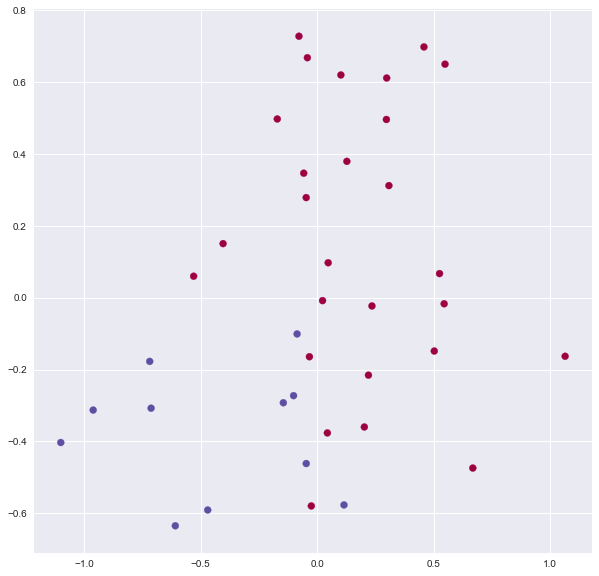

In [116]:
plt.figure(figsize=(10,10))
plt.scatter(X[:,best_features_scoring[0]], X[:,best_features_scoring[1]], c=t, cmap=cm.Spectral)
plt.show()

In [98]:
best_features_scoring

array([196, 200,  22, 142, 280, 136,  29, 250, 223, 162, 193,  68, 203,
        83, 271, 278,  82, 295,  18, 256,  16, 124,  70, 176, 218, 106,
        48, 231,  54,  41, 224,  71, 119,  10,  47, 253, 121,  12,  67,
       144, 246, 104, 166,  33, 157, 174, 254, 125, 198, 158,  80, 285,
       190,  26,  98,  39, 227, 248,  20, 143, 141,  21,  30, 237, 214,
       135,  17, 262,   7,  96, 178, 270, 115,  77, 129, 257,  45, 187,
       131, 184,  55,  31, 123, 260,  85,  90, 282, 139, 132, 137,  11,
       168,   8, 105,  32,   1, 299,  36, 274,  52, 258, 284, 242, 163,
       116,  28, 213,  64, 281, 221, 122, 251,  84, 273, 111, 127, 240,
       108, 206, 244,  72, 171,  60, 112, 265, 298, 180, 199, 110, 255,
        65, 117,  97,  74, 294, 147, 287, 272, 165, 177, 153, 266, 148,
        44,  40,  75, 149, 118,  94, 150, 235, 230,  23, 261, 283, 155,
       263,  62, 145,  79,  35, 233, 211,  66, 297, 202, 102,  89, 159,
       207, 293, 183, 243,  76,  51,  58, 170, 188,  87, 107, 11

<h4>2.1.2 Clustering</h4>

You can use the K-means code you wrote last week. Remember to pass the data the correct way around and only cluster the training data. Transforming the test data is a little more complex –your kmeans should give you assignments of features to clusters. Use these alongside the test data to compute the cluster means for the test data (you do not need to re-assign the clusterings).

In [99]:
def euclidean_distance(p1, p2):
    return np.linalg.norm(np.array(p1)-np.array(p2))

def find_closest_centroid(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
    distances = [euclidean_distance(datapoint, _) for _ in centroids]
    return np.argmin(distances)

def randomize_centroids(data, k):
    centroids = data
    np.random.shuffle(centroids)
    return centroids[:k]

MAX_ITERATIONS = 500

def check_converge(centroids, old_centroids, num_iterations, threshold=0):
    # if it reaches an iteration budget
    if num_iterations > MAX_ITERATIONS:
        return True
    # check if the centroids don't move (or very slightly)
    dist = [euclidean_distance(curr, old) for curr, old in zip(centroids, old_centroids)]
    if all(dist[x]<=threshold for x in range(len(dist))):
        return True
    return False

def update_centroids(centroids, cluster):
    for i, c in enumerate(cluster):
        centroids[i] = sum(c)/len(c)
    return centroids

In [100]:
# data : set of data points
# k : number of clusters
# centroids: initial list of centroids
def kmeans(data, k=2, centroids=None):
    
    # randomize the centroids if they are not given
    if not centroids:
        centroids = randomize_centroids(data, k)

    old_centroids = centroids[:]

    iterations = 0
    while True:
        iterations += 1

        # init empty clusters
        clusters = [[] for i in range(k)]

        # assign each data point to the closest centroid
        for point in data:
            # find the closest center of each data point
            centroid_idx = find_closest_centroid(point, centroids)
            
            # assign datapoint to the closest cluster
            clusters[centroid_idx].append(point)
        
        # keep the current position of centroids before changing them
        old_centroids = centroids[:]
        
        # update centroids
        centroids = update_centroids(clusters, clusters)
        
        # if the stop criteria are met, stop the algorithm
        if check_converge(centroids, old_centroids, iterations):
            break
    return np.array(centroids), iterations

In [104]:
new_data = kmeans(data=X.T)[0].T

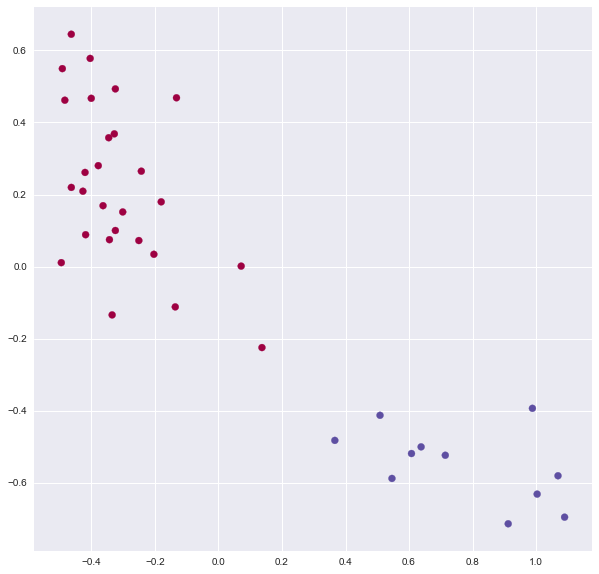

In [108]:
plt.figure(figsize=(10,10))
plt.scatter(new_data[:,0], new_data[:,1], c=t, cmap=cm.Spectral)
plt.show()

In [82]:
def plot_kmeans(data):
    fig, axes = plt.subplots(2,2)
    for k, ax in zip([2,3,4,5], axes.flatten()):
        t0 = time.time()
        centroids, iterations = kmeans(data, k=k)
        t1 = time.time()
        labels = [find_closest_centroid(x, centroids) for x in data]

        #PLOTTING
        #plt.title("K-means with k=" + str(k) + " time=" + str(t1-t0) + " iterations=" + str(iterations))
        ax.set_title("K-means with k=" + str(k) + " time=" + str(t1-t0) + " iterations=" + str(iterations))

        ax.scatter(data[:,0], data[:,1], c=labels, cmap=cm.Spectral)

        ax.scatter(centroids[:,0], centroids[:,1], c=np.arange(k), cmap=cm.Spectral, s=300)
        ax.axis([-6,6,-6,6])
    plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plot_kmeans(X.T)